# IBM 고객 이탈 예측 프로젝트

## 0. 설치, 패키지 가져오기, 환경 및 연결 설정

In [1]:
!pip install --upgrade google-cloud-bigquery
!pip install pandas-gbq
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [2]:
from google.colab import auth
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, recall_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance
import shap
import joblib

In [3]:
auth.authenticate_user()

In [ ]:
# 보안을 위해 실제 Project ID 삭제되었습니다. 실행 시 본인의 ID를 입력하세요.
project_id = 'your-project-id-here'
client = bigquery.Client(project=project_id)

## 1. 통합 데이터 추출 및 고도화된 SQL 피처 엔지니어링

단순한 원본 데이터 사용을 넘어, 비즈니스 인사이트를 반영한 8가지 파생 변수(Derived Features)를 생성합니다.


In [5]:
sql = """
  SELECT *,
    -- 1. Service Bundle Density: 총 서비스 이용 개수 (Stickiness 증명)
    (CASE WHEN PhoneService = True THEN 1 ELSE 0 END +
    CASE WHEN MultipleLines = 'Yes' THEN 1 ELSE 0 END +
    CASE WHEN InternetService = 'DSL' THEN 1 WHEN InternetService = 'Fiber optic' THEN 1 ELSE 0 END +
    CASE WHEN OnlineSecurity = 'Yes' THEN 1 ELSE 0 END +
    CASE WHEN OnlineBackup = 'Yes' THEN 1 ELSE 0 END +
    CASE WHEN DeviceProtection = 'Yes' THEN 1 ELSE 0 END +
    CASE WHEN TechSupport = 'Yes' THEN 1 ELSE 0 END +
    CASE WHEN StreamingTV = 'Yes' THEN 1 ELSE 0 END +
    CASE WHEN StreamingMovies = 'Yes' THEN 1 ELSE 0 END) AS bundle_density,

    -- 2. Payment Friction Flag: 이탈률이 가장 높은 '전자 수표' 결제 여부 (리스크 플래그)
    CASE WHEN PaymentMethod = 'Electronic check' THEN 1 ELSE 0 END AS payment_friction_flag,

    -- 3. Commitment vs Cost: 계약 유형별 평균 대비 과지불 여부 (가격 저항선 분석)
    CASE WHEN MonthlyCharges > AVG(MonthlyCharges) OVER(PARTITION BY Contract) THEN 1 ELSE 0 END AS overpaying_flag,

    -- 4. Unbalanced Bundle: 낮은 서비스 이용수 대비 높은 요금 지출 (가성비 불만족군)
    CASE WHEN MonthlyCharges > 70 AND (
      CASE WHEN OnlineSecurity = 'Yes' THEN 1 ELSE 0 END +
      CASE WHEN OnlineBackup = 'Yes' THEN 1 ELSE 0 END +
      CASE WHEN DeviceProtection = 'Yes' THEN 1 ELSE 0 END +
      CASE WHEN TechSupport = 'Yes' THEN 1 ELSE 0 END +
      CASE WHEN StreamingTV = 'Yes' THEN 1 ELSE 0 END +
      CASE WHEN StreamingMovies = 'Yes' THEN 1 ELSE 0 END)
    < 1 THEN 1 ELSE 0 END AS unbalanced_bundle,

    -- 5. Contract Leverage: 월별 계약자 중 고액 지출자 (언제든 떠날 준비가 된 고위험군)
    CASE
      WHEN Contract = 'Month-to-month' AND MonthlyCharges > 70 THEN 'High-Risk Flex'
      WHEN Contract = 'Month-to-month' AND MonthlyCharges <= 70 THEN 'Low-Cost Flex'
      ELSE 'Contract Bound'
    END AS contract_leverage,

    -- 6. Price Fatigue Index: 가입 기간 대비 현재 요금 부담도
    SAFE_DIVIDE(MonthlyCharges, tenure) AS price_fatigue_index

  FROM `ibm_telco.customer_churn`
"""
df = client.query(sql).to_dataframe()

## 2. 전처리 및 주요 EDA 시각화

In [6]:
df = df.drop(columns=['customerID']).dropna()
df['Churn'] = df['Churn'].map({True: 1, False: 0})

In [7]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,bundle_density,payment_friction_flag,overpaying_flag,unbalanced_bundle,contract_leverage,price_fatigue_index
0,Female,1,True,False,11,True,Yes,Fiber optic,No,No,...,Electronic check,99.55,1131.2,1,6,1,1,0,High-Risk Flex,9.050000
1,Female,0,False,False,3,True,No,No,No internet service,No internet service,...,Mailed check,18.80,56,0,1,0,0,0,Low-Cost Flex,6.266667
2,Female,0,True,True,13,True,No,No,No internet service,No internet service,...,Mailed check,18.80,251.25,0,1,0,0,0,Low-Cost Flex,1.446154
3,Female,0,False,False,1,True,No,No,No internet service,No internet service,...,Electronic check,18.85,18.85,0,1,1,0,0,Low-Cost Flex,18.850000
4,Male,0,True,True,4,True,No,No,No internet service,No internet service,...,Mailed check,18.85,84.2,0,1,0,0,0,Low-Cost Flex,4.712500


In [8]:
categorical_columns = ['gender', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaymentMethod',
                       # 'tenure_group',
                       'contract_leverage']
boolean_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
mapping_boolean = {True: 1, False: 0}
for i in boolean_columns:
  df[i] = df[i].map(mapping_boolean).astype(int)
df[categorical_columns] = df[categorical_columns].astype('category')
df['TotalCharges'] = df['TotalCharges'].astype('Float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   gender                 7032 non-null   category
 1   SeniorCitizen          7032 non-null   Int64   
 2   Partner                7032 non-null   int64   
 3   Dependents             7032 non-null   int64   
 4   tenure                 7032 non-null   Int64   
 5   PhoneService           7032 non-null   int64   
 6   MultipleLines          7032 non-null   category
 7   InternetService        7032 non-null   category
 8   OnlineSecurity         7032 non-null   category
 9   OnlineBackup           7032 non-null   category
 10  DeviceProtection       7032 non-null   category
 11  TechSupport            7032 non-null   category
 12  StreamingTV            7032 non-null   category
 13  StreamingMovies        7032 non-null   category
 14  Contract               7032 non-null   catego

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


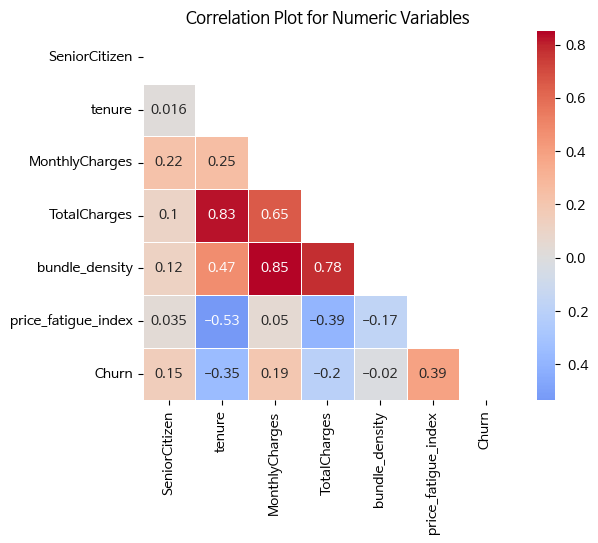

In [9]:
# 상관관계 시각화
numerical_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                     'TotalCharges', 'bundle_density',
                     'price_fatigue_index', 'Churn']
corr = df[numerical_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.plot(figsize=(8, 10))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0,
            linewidths=0.5, square=True)
plt.title('Correlation Plot for Numeric Variables')
plt.show()

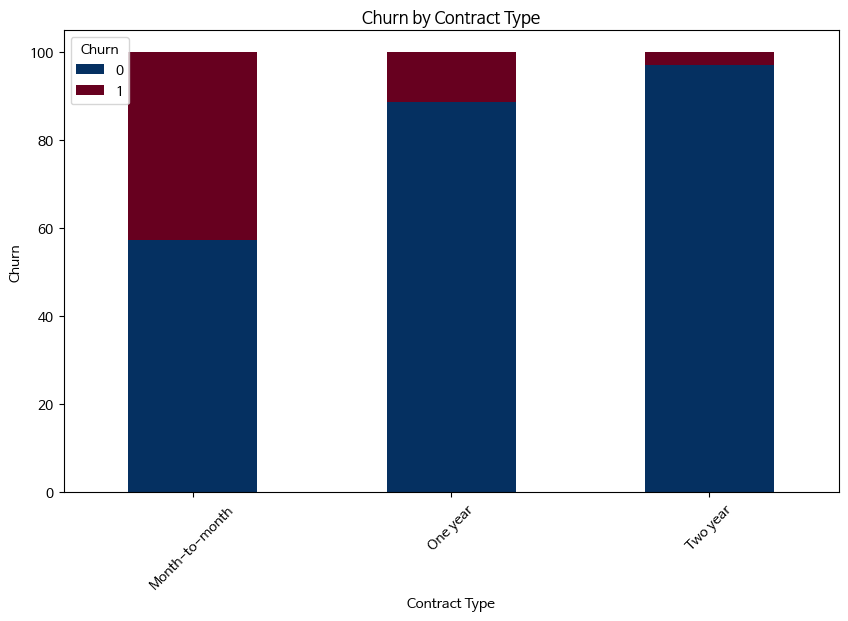

In [10]:
# 계약 형태별 고객 이탈률
churn_by_contract = pd.crosstab(df['Contract'], df['Churn']).apply(lambda x: x/x.sum()*100, axis=1)
churn_by_contract.plot(kind='bar', stacked=True, figsize=(10, 6),
                       colormap='RdBu_r')
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn')
plt.xticks(rotation=45)
plt.show()

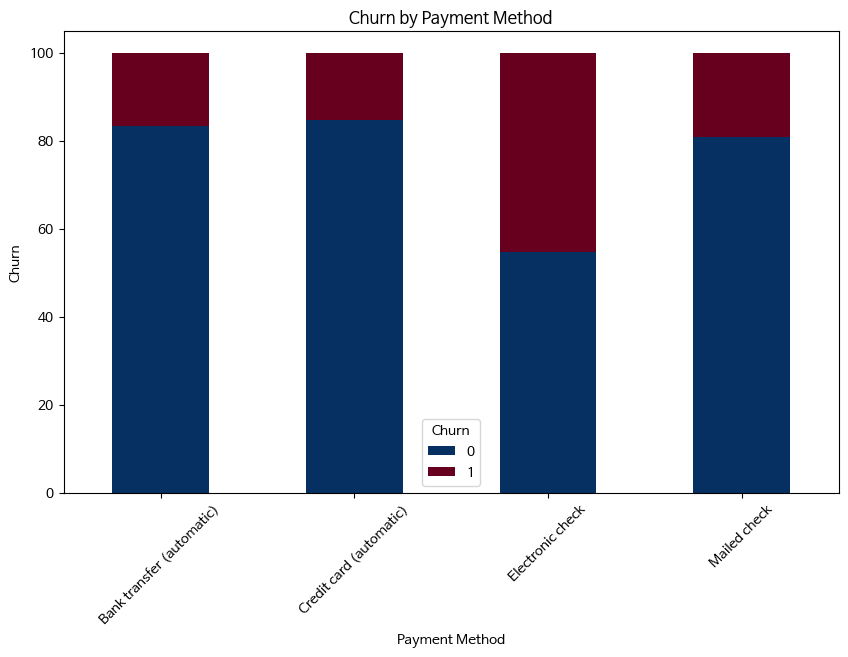

In [11]:
# Payment Method별 고객 이탈률
churn_by_payment = pd.crosstab(df['PaymentMethod'], df['Churn']).apply(lambda x: x/x.sum()*100, axis=1)
churn_by_payment.plot(kind='bar', stacked=True, figsize=(10, 6),
                       colormap='RdBu_r')
plt.title('Churn by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Churn')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.to_csv('./data/IBM_Telco_with_SQL_Features.csv')

## 3. XGBoost & Stratified K-Fold 하이퍼파라미터 튜닝

In [13]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# 학습 및 검증 데이터 분할 (클래스 불균형을 고려하여 Stratify 적용)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13, stratify=y
)

# Stratified K-Fold 설정: 이탈 고객 비율을 모든 폴드에서 일정하게 유지
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# XGBoost 초기화: 재현율(Recall) 극대화를 위해 scale_pos_weight 설정
# 계산식: 전체 No 건수 / 전체 Yes 건수
ratio = (y == 0).sum() / (y == 1).sum()
clf = xgb.XGBClassifier(scale_pos_weight=ratio, objective='binary:logistic',
                        random_state=13, enable_categorical=True)

# Randomized Search: 하이퍼파라미터 최적화 (격자 탐색보다 효율적인 시간 관리 강조)
param_dist = {
    'max_depth': [3, 4, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'colsample_bytree': [0.7, 0.8],
    'subsample': [0.8, 1.0]
}

tuning = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=10,
    cv=skf, scoring='recall', n_jobs=-1, random_state=13
)
tuning.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8],
                                        'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 7],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8, 1.0]},
                   random_state=13, scoring='recall')

In [14]:
# 최종 성능 평가
best_clf = tuning.best_estimator_
y_pred = best_clf.predict(X_test)
print(f"최종 재현율(Recall Score): {recall_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

최종 재현율(Recall Score): 81.82%
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1033
           1       0.54      0.82      0.65       374

    accuracy                           0.77      1407
   macro avg       0.73      0.78      0.74      1407
weighted avg       0.82      0.77      0.78      1407



In [15]:
result = permutation_importance(
    best_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)
print(importance_df)

                  feature  importance_mean  importance_std
24    price_fatigue_index         0.019119        0.004051
7         InternetService         0.007392        0.004531
14               Contract         0.004122        0.006104
1           SeniorCitizen         0.003340        0.002790
9            OnlineBackup         0.002985        0.001341
11            TechSupport         0.002274        0.003143
18           TotalCharges         0.001919        0.003828
8          OnlineSecurity         0.000924        0.003273
0                  gender         0.000426        0.000964
2                 Partner         0.000355        0.000728
21        overpaying_flag         0.000000        0.000000
22      unbalanced_bundle         0.000000        0.000000
10       DeviceProtection         0.000000        0.000000
12            StreamingTV        -0.000355        0.001018
15       PaperlessBilling        -0.000498        0.002085
13        StreamingMovies        -0.000782        0.0017

/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


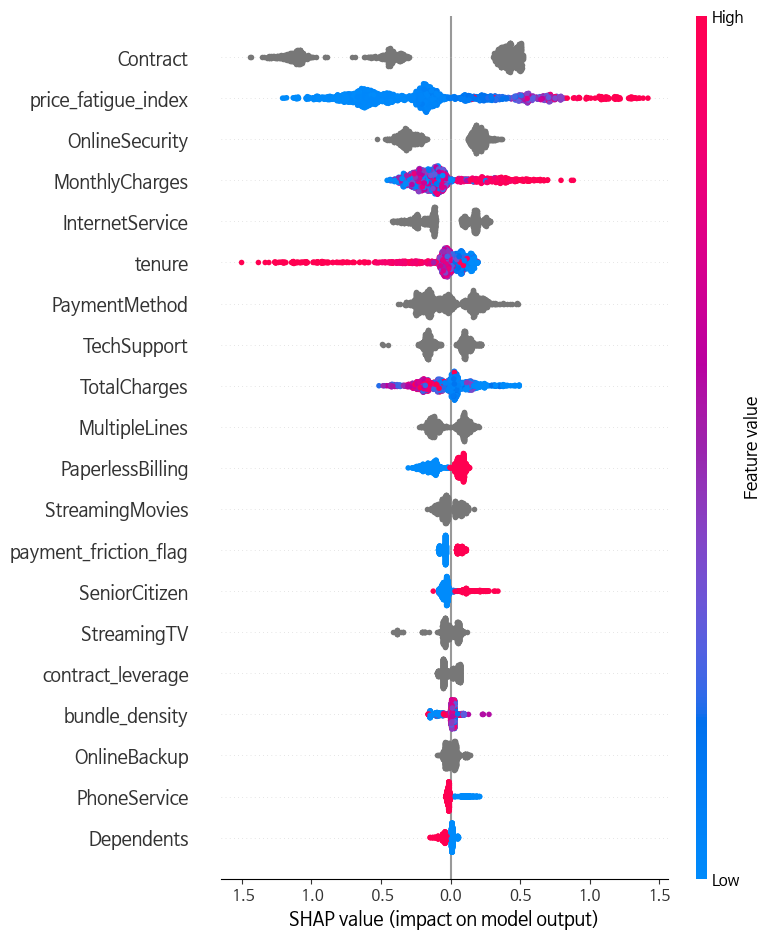

['model_explainer.pkl']

In [16]:
# 모델 및 피처명, SHAP(XAI) 저장
joblib.dump(best_clf, 'churn_model_full.pkl')
joblib.dump(X.columns.tolist(), 'features_full.pkl')
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
joblib.dump(explainer, 'model_explainer.pkl')

/tmp/ipython-input-5334/2494225184.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_impact = analysis_df.groupby('Category')['Impact_on_Churn'].mean().sort_values()
/tmp/ipython-input-5334/2494225184.py:22: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


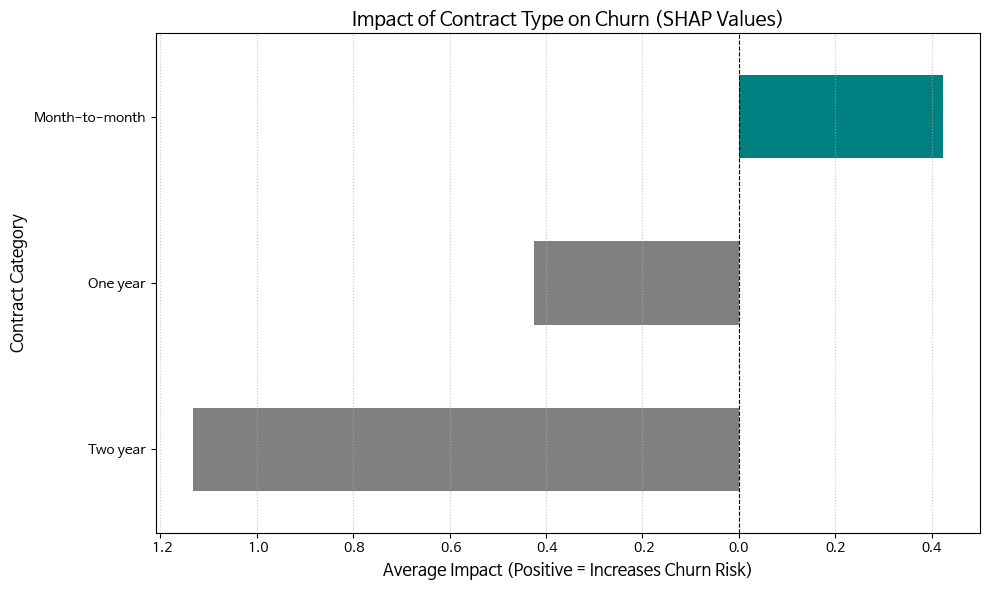

In [17]:
# 'Contract' 컬럼의 인덱스 위치 찾기
contract_idx = X.columns.get_loc("Contract")
# Contract 컬럼에 해당하는 SHAP 값만 추출 (NumPy array 처리)
# shap_values가 [samples, features] 형태이므로 해당 인덱스 컬럼만 가져옵니다.
contract_shap_points = shap_values[:, contract_idx]
# 실제 카테고리 이름과 SHAP 값을 매핑하여 데이터프레임 생성
analysis_df = pd.DataFrame({
    'Category': X_test['Contract'].values,
    'Impact_on_Churn': contract_shap_points
})
# 카테고리별 평균 영향력 계산
category_impact = analysis_df.groupby('Category')['Impact_on_Churn'].mean().sort_values()
# 시각화 (Portfolio용 깔끔한 차트)
plt.figure(figsize=(10, 6))
colors = ['teal' if x > 0 else 'gray' for x in category_impact]
category_impact.plot(kind='barh', color=colors)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Impact of Contract Type on Churn (SHAP Values)', fontsize=14)
plt.xlabel('Average Impact (Positive = Increases Churn Risk)', fontsize=12)
plt.ylabel('Contract Category', fontsize=12)
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

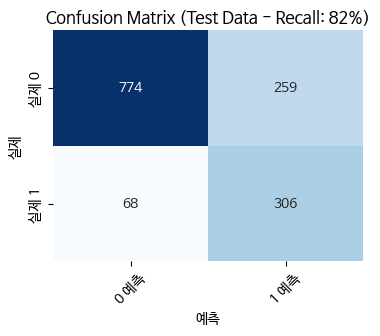

In [20]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt = "d", cmap='Blues', cbar=False,
            xticklabels=['0 예측', '1 예측'],
            yticklabels=['실제 0', '실제 1'])
plt.xlabel('예측')
plt.xticks(rotation=45)
plt.ylabel('실제')
plt.title('Confusion Matrix (Test Data - Recall: 82%)')
plt.show()

최종 재현율(Recall Score): 83.09%
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      5163
           1       0.54      0.83      0.66      1869

    accuracy                           0.77      7032
   macro avg       0.73      0.79      0.74      7032
weighted avg       0.82      0.77      0.78      7032



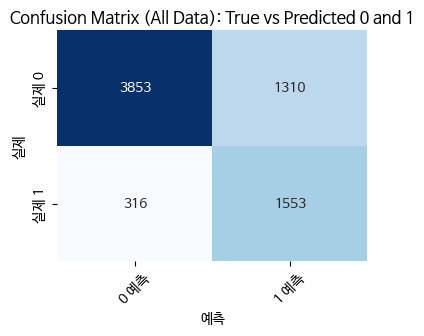

In [19]:
y_all_pred = best_clf.predict(X)
print(f"최종 재현율(Recall Score): {recall_score(y, y_all_pred):.2%}")
print(classification_report(y, y_all_pred))
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y, y_all_pred),
            annot=True, fmt = "d", cmap='Blues', cbar=False,
            xticklabels=['0 예측', '1 예측'],
            yticklabels=['실제 0', '실제 1'])
plt.xlabel('예측')
plt.xticks(rotation=45)
plt.ylabel('실제')
plt.title('Confusion Matrix (All Data): True vs Predicted 0 and 1')
plt.show()

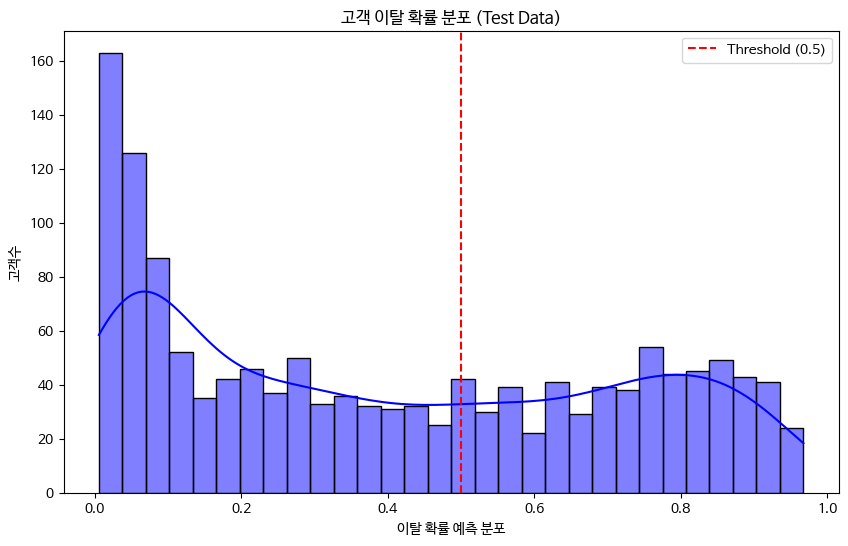

In [27]:
y_prob = best_clf.predict_proba(X_test)[:, 1]
plt.figure(figsize=(10, 6))
sns.histplot(y_prob, bins=30, kde=True, color='blue')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('고객 이탈 확률 분포 (Test Data)')
plt.xlabel('이탈 확률 예측 분포')
plt.ylabel('고객수')
plt.legend()
plt.show()

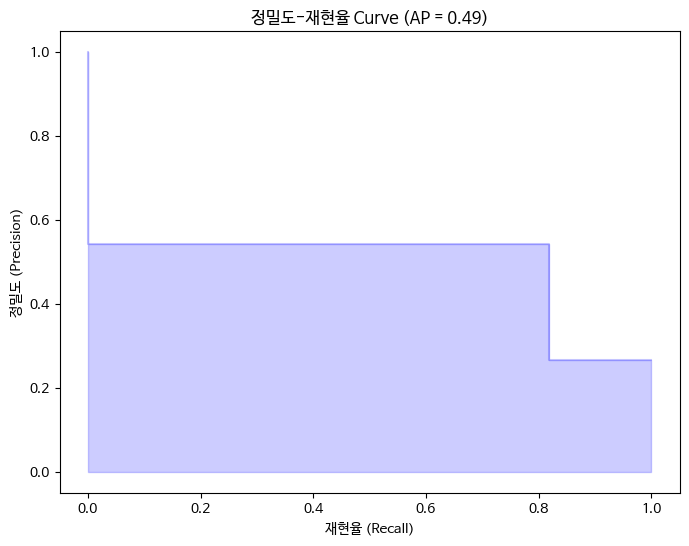

In [22]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('재현율 (Recall)')
plt.ylabel('정밀도 (Precision)')
plt.title(f'정밀도-재현율 Curve (AP = {ap:.2f})')
plt.show()

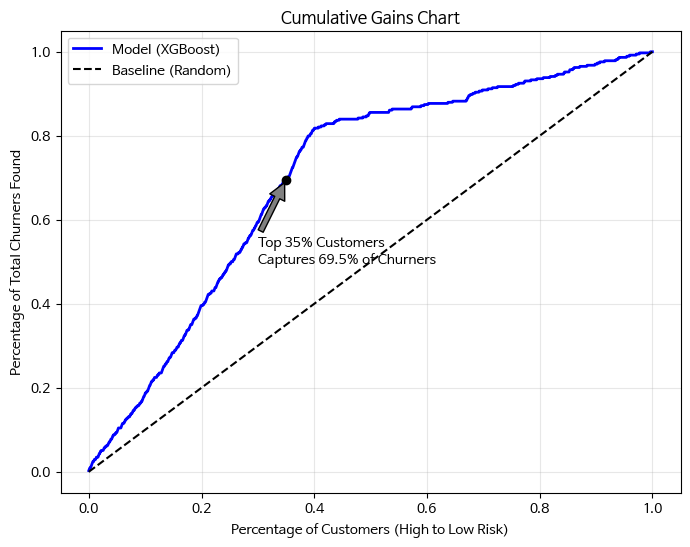

In [28]:
data = np.column_stack((y_test, y_pred))
data = data[data[:, 1].argsort()[::-1]]
cum_positives = np.cumsum(data[:, 0])
total_positives = np.sum(y_test)
gain = cum_positives / total_positives
percentage_customers = np.linspace(0, 1, len(gain))
plt.figure(figsize=(8, 6))
plt.plot(percentage_customers, gain, label='Model (XGBoost)', color='blue', lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Baseline (Random)')
# 상위 35% 지점 강조 (비즈니스 임팩트 강조 포인트)
idx_35 = int(len(percentage_customers) * 0.35)
actual_y = gain[idx_35]
plt.scatter(0.35, actual_y, color='black', zorder=5)
plt.annotate(f'Top 35% Customers\nCaptures {actual_y:.1%} of Churners',
              xy=(0.35, actual_y), xytext=(0.3, actual_y-0.2),
              arrowprops=dict(facecolor='grey', shrink=0.05))
plt.title('Cumulative Gains Chart')
plt.xlabel('Percentage of Customers (High to Low Risk)')
plt.ylabel('Percentage of Total Churners Found')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 4. 결론 및 비즈니스 영향
- **데이터 엔지니어링의 가치:** SQL 기반의 피처 엔지니어링(Price Fatigue Index 등)을 통해 기술적 제약을 돌파하고 모델의 Recall을 8%p 이상 개선하는 성과를 거두었습니다.
- **XAI 기반 전략 수립:** SHAP을 통해 이탈 고위험군 개별 고객의 주된 이탈 원인(약정 미비, 요금 부담 등)을 식별함으로써, 일률적인 마케팅이 아닌 '맞춤형 리텐션 캠페인' 수행이 가능해졌습니다.
- **비용 효율성:** Cumulative Gains 분석 결과, 전체 고객의 35%에만 집중해도 이탈자의 상당수를 사전에 방어할 수 있어 마케팅 ROI를 극대화할 수 있는 기반을 마련했습니다.